# Multi-fluid Parameter Fitting

Here is an example of fitting the $\beta_T$ and $\gamma_T$ values for the binary pair of propane+$n$-dodecane with the multi-fluid model. It uses differential evolution to do the global optimization, which is probably overkill in this case as the problem is 2D and other algorithms like Nelder-Mead or even approximate Hessian methods would probably be fine.

In any case, it takes a few seconds to run (when the actual optimization is uncommented), demonstrating how one can fit model parameters with existing tooling from the scientific python stack.

In [1]:
import json 
import teqp, numpy as np, pandas, matplotlib.pyplot as plt
import scipy.interpolate, scipy.optimize

import pandas
data = pandas.read_csv('VLE_data_propane_dodecane.csv')

In [2]:
def cost_function(parameters:np.ndarray, plot:bool=False):

    # Fitting some parameters and fixing the others
    betaV, gammaV = 1.0, 1.0
    betaT, gammaT = parameters

    # betaT, gammaT, betaV, gammaV = parameters

    BIP = [{
        'function': '',
        'BibTeX': 'thiswork',
        'CAS1': '112-40-3',
        'CAS2': '74-98-6',
        'F': 0.0,
        'Name1': 'n-Dodecane',
        'Name2': 'n-Propane',
        'betaT': betaT,
        'betaV': betaV,
        'gammaT': gammaT,
        'gammaV': gammaV
    }]
    model = teqp.build_multifluid_model(["n-Dodecane", "n-Propane"], teqp.get_datapath(), 
        BIPcollectionpath=json.dumps(BIP)
    )
    ancs = [model.build_ancillaries(ipure) for ipure in [0,1]]

    cost = 0.0
    
    # The 0-based index of the fluid to start from. At this temperature, only one fluid 
    # is subcritical, so it has to be that one, but in general you could start 
    # from either one.
    ipure = 0 

    for T in [419.15, 457.65]:
        # Subset the experimental data to match the isotherm 
        # being fitted
        dfT = data[np.abs(data['T / K90'] - T) < 1e-3]

        if plot:
            plt.plot(1-dfT['x[0] / mole frac.'], dfT['p / Pa']/1e6, 'X')
            plt.plot(1-dfT['y[0] / mole frac.'], dfT['p / Pa']/1e6, 'X')

        try:
            # Get the molar concentrations of the pure fluid
            # at the starting point
            anc = ancs[ipure]
            rhoL0 = np.array([0, 0.0])
            rhoV0 = np.array([0, 0.0])
            rhoL0[ipure] = anc.rhoL(T)
            rhoV0[ipure] = anc.rhoV(T)

            # Now we do the trace and convert retuned JSON
            # data into a DataFrame
            df = pandas.DataFrame(model.trace_VLE_isotherm_binary(T, rhoL0, rhoV0))
            
            if plot:
                plt.plot(df['xL_0 / mole frac.'], df['pL / Pa']/1e6)
                plt.plot(df['xV_0 / mole frac.'], df['pL / Pa']/1e6)

            # Interpolate trace at experimental pressures along this 
            # isotherm to get composition from the current model
            # The interpolators are set up to put in NaN for out
            # of range values
            x_interpolator = scipy.interpolate.interp1d(
                df['pL / Pa'], df['xL_0 / mole frac.'], 
                fill_value=np.nan, bounds_error=False
            )
            y_interpolator = scipy.interpolate.interp1d(
                df['pL / Pa'], df['xV_0 / mole frac.'], 
                fill_value=np.nan, bounds_error=False
            )
            # The interpolated values for the compositions 
            # along the trace at experimental pressures
            x_model = x_interpolator(dfT['p / Pa'])
            y_model = y_interpolator(dfT['p / Pa'])
            if plot:
                plt.plot(x_model, dfT['p / Pa']/1e6, '.')
            
            # print(x_model, (1-dfT['x[0] (-)']))
            
            errTx = np.sum(np.abs(x_model-(1-dfT['x[0] / mole frac.'])))
            errTy = np.sum(np.abs(y_model-(1-dfT['y[0] / mole frac.'])))
            
            # If any point *cannot* be interpolated, throw out the model,
            # returning a large cost function value.
            #
            # Note: you might need to be more careful here,
            # if the points are close to the critical point, a good model might
            # (but not usually), undershoot the critical point of the 
            # real mixture
            # 
            # Also watch out for values of compositons in the data that are placeholders
            # with a value of nan, which will pollute the error calculation
            if not np.isfinite(errTx):
                return 1e6
            if not np.isfinite(errTy):
                return 1e6
            cost += errTx + errTy

        except BaseException as BE:
            print(BE)
            pass 
    if plot:
        plt.title(f'dodecane(1) + propane(2)')
        plt.xlabel('$x_1$ / mole frac.'); plt.ylabel('$p$ / MPa')
        plt.savefig('n-Dodecane+propane.pdf')
        plt.show()

    return cost

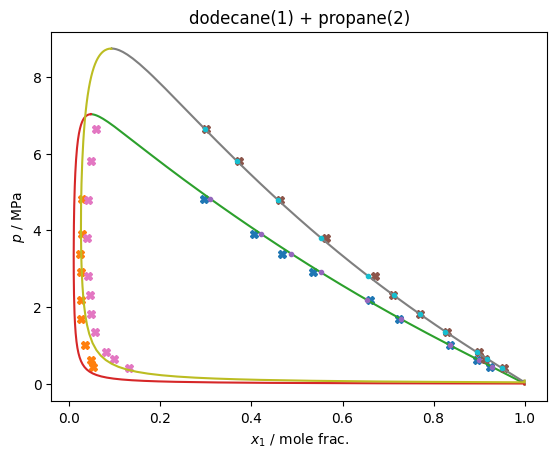

0.47041664920218196

In [3]:
# The final parameter values, will be overwritten if 
# optimization call is uncommented
x = [1.01778992, 1.17318854]

# Here is the code used to do the optimization, uncomment to run it
# Note: it is commented out because it takes too long to run on doc builder
#
# res = scipy.optimize.differential_evolution(
#     cost_function, 
#     bounds=((0.9, 1.5), (0.75, 1.5)), 
#     disp=True, 
#     polish=False
# )
# print(res)
# x = res.x

cost_function(x, plot=True)